In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
from mne.stats import permutation_cluster_1samp_test


# Frequency tagging

In [2]:
# snrs 
participants = ['A0', 'A1', 'A2'] 
ami = []
for participant in participants:
    df_participant = np.load(f'files/{participant}_ami.npy')
    ami.append(df_participant)
ami = np.stack(ami)
ami = pd.DataFrame(ami, columns=['60',
                                '64'])
ami['participant'] = participants
ami = ami.melt(id_vars='participant')

split_data = ami['variable'].str.split(' & ', expand=True)
ami['frequency'] = split_data[0]
ami = ami.drop(columns=['variable'])
# Average over stimulation frequencies
ami = ami.groupby(['participant']).value.mean().reset_index()


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(47.89833670910494, 0.5, 'Attention modulation index')

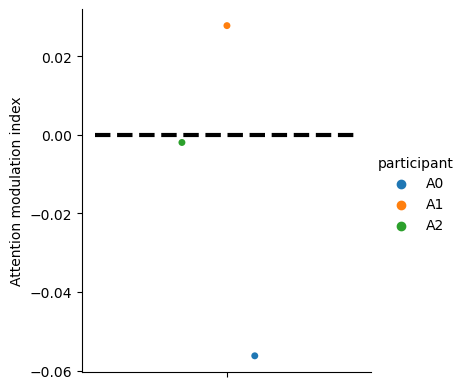

In [3]:
sns.catplot(y='value', hue='participant',
            data=ami, height=4)
plt.hlines(0, -.25, .25, color='black', ls='--', lw=3)
plt.ylabel('Attention modulation index')

In [4]:
print(f'mean = {ami.value.mean()}')
print(f'SD = {ami.value.std()}')

mean = -0.010110137334925688
SD = 0.04264686272675085


In [5]:
print(f'T-test for the AMI :{ttest_1samp(ami.value, 0)}')


T-test for the AMI :TtestResult(statistic=-0.4106110137054959, pvalue=0.7211692115565822, df=2)


## 1.2 Coherence analysis

In [6]:
participants = ['A0', 'A1', 'A2'] 

ms_coh = []
for participant in participants:
    df_participant = pd.read_csv(f'files/ITcoh_{participant}.csv', index_col=False)
    df_participant['participant'] = participant
    ms_coh.append(df_participant)
ms_coh = pd.concat(ms_coh)
ms_coh['cued_group'] = (ms_coh['coh_with'] == ms_coh['cued'])
#Average over electrodes
ms_coh = ms_coh.groupby(['participant','time','cued_group']).ITcoherence.mean().reset_index()
ms_coh = ms_coh[(ms_coh.time > -0.1) & (ms_coh.time < 2)]

In [7]:
diff_coh = pd.merge(ms_coh[ms_coh.cued_group == True],
                    ms_coh[ms_coh.cued_group == False], 
                    on=['time', 'participant'], suffixes=('_1', '_2'))

# Calculate the difference in ITcoherence
diff_coh['ms_coherence_diff'] = diff_coh['ITcoherence_2'] - diff_coh['ITcoherence_1']

Using a threshold of 4.302653
stat_fun(H1): min=-4.577768201344677 max=2.4726234634303217
Running initial clustering …
Found 2 clusters


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

  0%|          | Permuting (exact test) : 0/3 [00:00<?,       ?it/s]

Time at which coherence difference is maximum: 1.0208333333333337
Time at which coherence difference is maximum: 1.7125


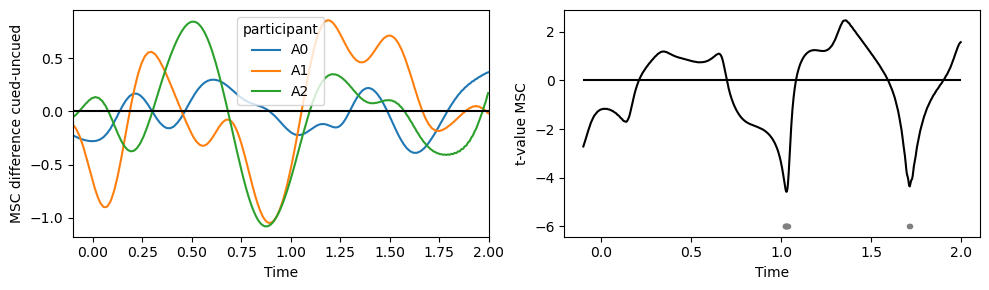

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.lineplot(y='ms_coherence_diff', x='time', data=diff_coh,hue='participant', ax=ax[0])
ax[0].hlines(0, -.1, 2, 'k')
ax[0].set_xlim(-.1, 2)
# ax[0].set_ylim(-1, 1)
ax[0].set_ylabel('MSC difference cued-uncued')
ax[0].set_xlabel('Time')

X = diff_coh.ms_coherence_diff.values.reshape((3, len(diff_coh.time.unique())))
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(X)
ax[1].plot(diff_coh.time.unique(), T_obs, color='black')
for clust in clusters:
    ax[1].plot(diff_coh.time.unique()[clust[0]], np.repeat(-6, len(clust[0])), '.', color='grey')
    max_T_obs_index = np.argmax(T_obs[clust[0]])
    max_T_obs_time = diff_coh.time.unique()[clust[0][max_T_obs_index]]
    print("Time at which coherence difference is maximum:", max_T_obs_time)

ax[1].hlines(0, -.1, 2, 'k')
# ax[1].set_xlim(-.2, 1)
ax[1].set_ylabel('t-value MSC')
ax[1].set_xlabel('Time')
plt.tight_layout()

## 2 Cross-correlation of the averaged tags 

### 2.1 Pre-post on averaged

In [9]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost_avgtag.csv', index_col=False)
    df_participant['Participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Max crosscorrelation'] = crosscorr['value']
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-tag', 'post': 'Post-tag'})


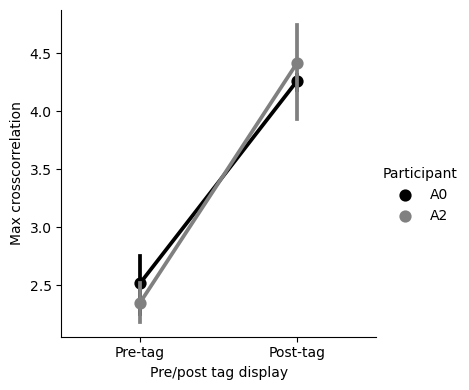

In [10]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display', hue='Participant', data=crosscorr, kind='point',  palette=['black','grey'], height=4, order=['Pre-tag', 'Post-tag'])

In [11]:
for participant, participant_data in crosscorr.groupby('Participant'):
    print(f'{participant} : {ttest_rel(participant_data[participant_data['prepost'] == 'pre'].value,
          participant_data[participant_data['prepost'] == 'post'].value)}')

A0 : TtestResult(statistic=-10.946668638678819, pvalue=0.0016320332494090069, df=3)
A2 : TtestResult(statistic=-8.471335582999822, pvalue=0.013649996767271143, df=2)


### 2.2 Comparing same vs other trials

In [12]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_averaged.csv', index_col=False)
    df_participant['Participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
# crosscorr = crosscorr.groupby(['participant','trial_type']).mean().reset_index()
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Same trials', 'other': 'Other trials'})


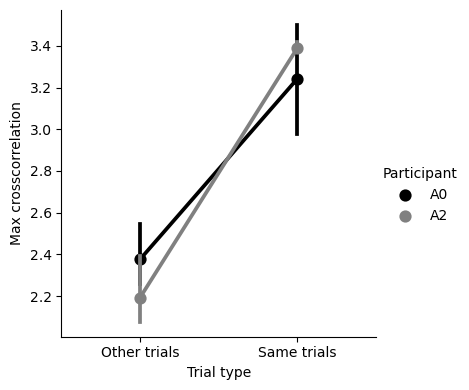

In [13]:
sns.catplot(y='Max crosscorrelation', x='Trial type', hue='Participant', data=crosscorr, kind='point',  palette=['black','grey'], height=4, order=['Other trials', 'Same trials'])

In [14]:
for participant, participant_data in crosscorr.groupby('Participant'):
    print(f'{participant} : {ttest_rel(participant_data[participant_data['trial_type'] == 'same'].value,
          participant_data[participant_data['trial_type'] == 'other'].value)}')

A0 : TtestResult(statistic=5.647968241782873, pvalue=0.01098578649510805, df=3)
A2 : TtestResult(statistic=11.038489073471942, pvalue=0.008107261931688967, df=2)


## 3 Search in subwindows of the tag

In [15]:
from noise_tagging_funs import generate_noise_periods

sfreq = 480 # EEG and tag tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1
tmax_eeg = 2.3

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 45
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq


### 3.1  Timing of the crosscorrelation with the average of the two tags

In [16]:
participants = ['A0', 'A2'] 
summed = []
for participant in participants:
    arr_participant = np.load(f'files/averaged_tags_{participant}.npy')
    summed.append(arr_participant)
summed = np.stack(summed)

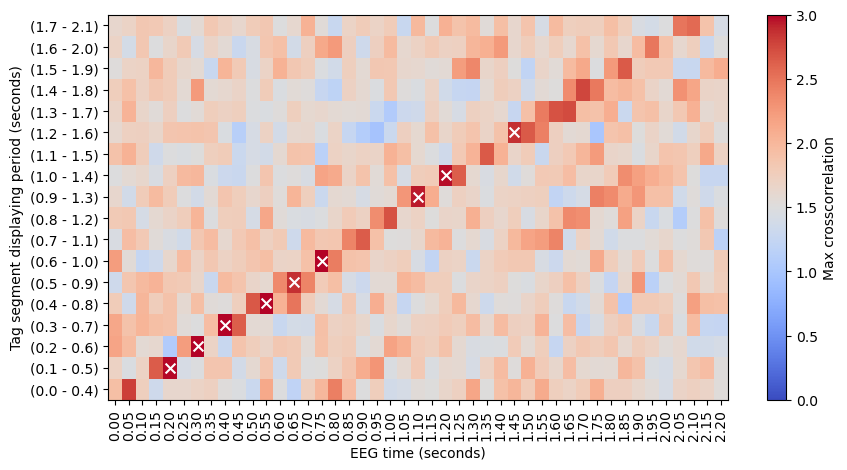

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
avg_summed = summed.mean(axis=0)
# Plot the heatmap
cax = ax.imshow(avg_summed, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

# Set labels and title
ax.set_xlabel('EEG time (seconds)')
ax.set_ylabel('Tag segment displaying period (seconds)')
# ax.set_title('Average of the two tags')

# Set x and y ticks
bin_times = np.linspace(start, end, n_bins)
ax.set_xticks(np.arange(n_bins))
ax.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
ax.set_yticks(np.arange(len(noise_periods)))
ax.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])

# Highlight values above 2.8
highlight_indices = np.where(avg_summed > 2.8)
ax.scatter(highlight_indices[1], highlight_indices[0],marker='x', color='white', linewidths=1.5, s=50)

plt.show()


In [18]:
idx_noise_periods, idx_bin_times = np.where(summed.mean(axis=0) > 2.8)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f} (zscore = {summed.mean(axis=0)[period, bin]})')

Significant for noise : [1.2 1.6] and bin 1.45 (zscore = 2.8603611033834553)
Significant for noise : [1.  1.4] and bin 1.20 (zscore = 2.965479322869969)
Significant for noise : [0.9 1.3] and bin 1.10 (zscore = 2.9393920566868577)
Significant for noise : [0.6 1. ] and bin 0.75 (zscore = 2.9897919714980112)
Significant for noise : [0.5 0.9] and bin 0.65 (zscore = 2.8641201799104055)
Significant for noise : [0.4 0.8] and bin 0.55 (zscore = 3.1606188906158823)
Significant for noise : [0.3 0.7] and bin 0.40 (zscore = 3.052894995955229)
Significant for noise : [0.2 0.6] and bin 0.30 (zscore = 3.293258954463579)
Significant for noise : [0.1 0.5] and bin 0.20 (zscore = 2.9874845070007012)


### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [19]:
participants = ['A0', 'A2'] 
cued, uncued = [], []
for participant in participants:
    arr_participant = np.load(f'files/cued_tags_with_target_{participant}.npy')
    cued.append(arr_participant)
    arr_participant = np.load(f'files/uncued_tags_with_target_{participant}.npy')
    uncued.append(arr_participant)
cued = np.stack(cued)
uncued = np.stack(uncued)

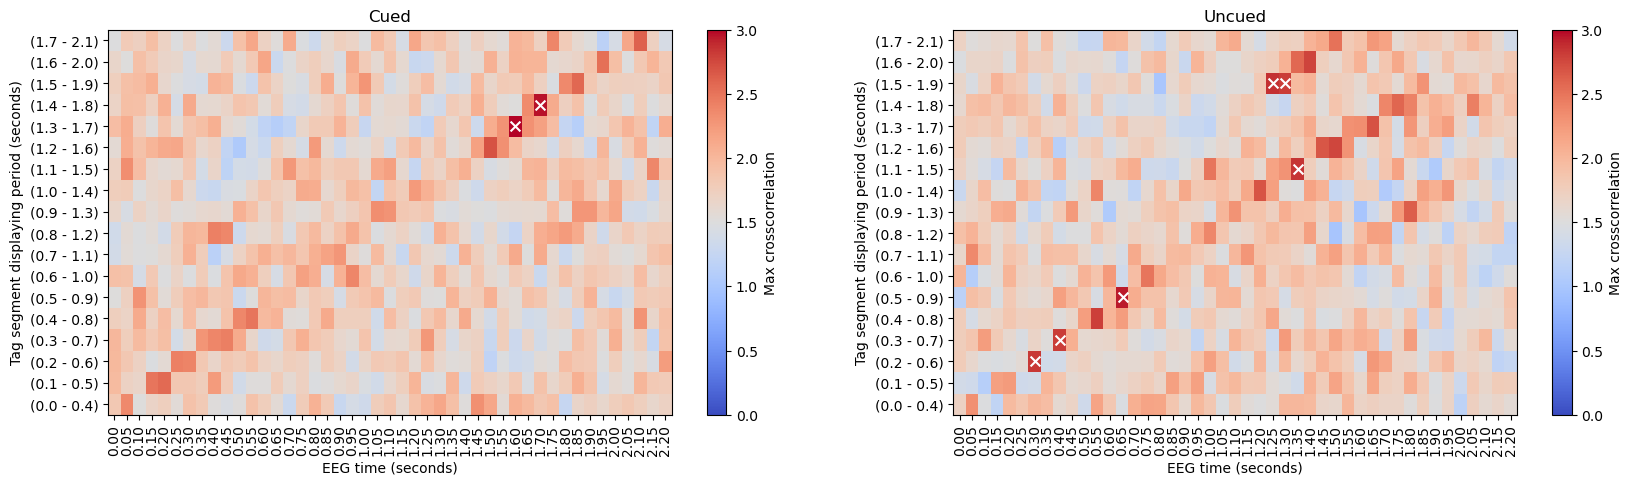

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
# Avertage over participants
cued_mean = cued.mean(axis=0)
uncued_mean = uncued.mean(axis=0)

# Plot the first heatmap for cued
cax = ax[0].imshow(cued_mean, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax, ax=ax[0])
cbar.set_label('Max crosscorrelation')

# Plot the second heatmap for uncued
cax = ax[1].imshow(uncued_mean, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax, ax=ax[1])
cbar.set_label('Max crosscorrelation')

threshold = 2.8
bin_times = np.linspace(start, end, n_bins)

for i, axi in enumerate(ax):
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])
    axi.set_xlabel('EEG time (seconds)')
    axi.set_ylabel('Tag segment displaying period (seconds)')
    
    # Highlight values above threshold
    if i == 0:
        highlight_indices = np.where(cued_mean > threshold)
    else:
        highlight_indices = np.where(uncued_mean > threshold)
    axi.scatter(highlight_indices[1], highlight_indices[0],marker='x', color='white', linewidths=1.5, s=50)

ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()
plt.show()

In [22]:
idx_noise_periods, idx_bin_times = np.where(cued.mean(axis=0) > 2.8)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Cued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f}  (zscore = {cued.mean(axis=0)[period, bin]})')

[Cued] Significant for noise : [1.4 1.8] and bin 1.70  (zscore = 2.963665216142141)
[Cued] Significant for noise : [1.3 1.7] and bin 1.60  (zscore = 3.0449670233301047)


In [23]:
idx_noise_periods, idx_bin_times = np.where(uncued.mean(axis=0) > 2.8)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Uncued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f}  (zscore = {uncued.mean(axis=0)[period, bin]})')

[Uncued] Significant for noise : [1.5 1.9] and bin 1.25  (zscore = 2.870720791003697)
[Uncued] Significant for noise : [1.5 1.9] and bin 1.30  (zscore = 2.809685983061562)
[Uncued] Significant for noise : [1.1 1.5] and bin 1.35  (zscore = 2.8379744450991558)
[Uncued] Significant for noise : [0.5 0.9] and bin 0.65  (zscore = 2.9352424336617777)
[Uncued] Significant for noise : [0.3 0.7] and bin 0.40  (zscore = 2.8042707155793245)
[Uncued] Significant for noise : [0.2 0.6] and bin 0.30  (zscore = 2.82777471206853)
